In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import numpy as np
from numpy import polyfit
import warnings
warnings.filterwarnings('ignore')

In [ ]:
! pip install arch

== Stationarity Tests ==
ADF Statistic: -2.1737
ADF p-value: 0.2159
KPSS Statistic: 4.1180
KPSS p-value: 0.0100
Phillips-Perron Statistic: -2.2633
PP p-value: 0.1841

== Noise and Randomness Tests ==
Ljung-Box test (lag 10):
       lb_stat     lb_pvalue
10  113.263607  1.170469e-19
Durbin-Watson Statistic: 2.3837
Variance Ratio Statistic: -0.8667
Variance Ratio p-value: 0.3861

== Time Series Decomposition ==


<ipython-input-6-296409504>:32: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(y, regression='c')


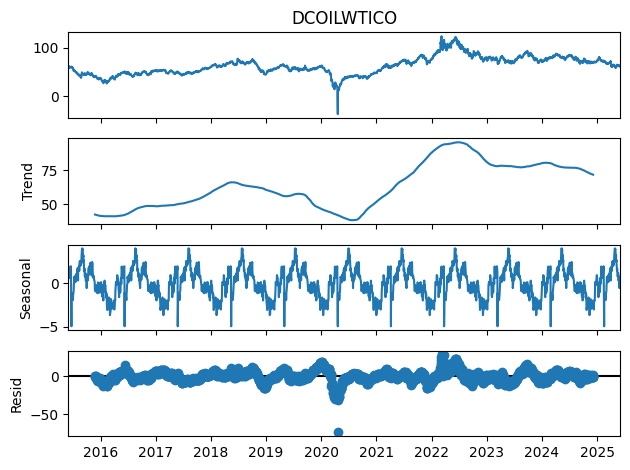

Noise (residual) descriptive statistics:
count    2358.000000
mean       -0.068758
std         6.872789
min       -74.103813
25%        -3.800737
50%         0.001027
75%         3.584765
max        28.474984
Name: resid, dtype: float64

== Spectral Analysis ==


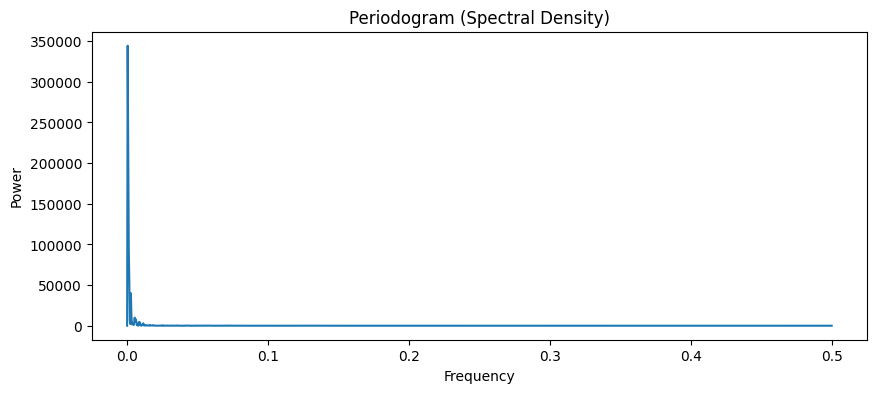


== ARCH Test ==
ARCH Test Statistic: 811.6799
ARCH Test p-value: 0.0000


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron, VarianceRatio
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal import periodogram

df = pd.read_csv('/content/drive/My Drive/OIL_CrUDE/DCOILWTICO.csv')

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df["observation_date"] = pd.to_datetime(df["observation_date"])
df['DCOILWTICO'] = df['DCOILWTICO'].fillna(method='ffill')

df = df.sort_values("observation_date")
df.set_index("observation_date", inplace=True)

y = df['DCOILWTICO']


print("== Stationarity Tests ==")
adf_result = adfuller(y)
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"ADF p-value: {adf_result[1]:.4f}")

kpss_result = kpss(y, regression='c')
print(f"KPSS Statistic: {kpss_result[0]:.4f}")
print(f"KPSS p-value: {kpss_result[1]:.4f}")

pp_test = PhillipsPerron(y)
print(f"Phillips-Perron Statistic: {pp_test.stat:.4f}")
print(f"PP p-value: {pp_test.pvalue:.4f}")

residuals = y.diff().dropna()

print("\n== Noise and Randomness Tests ==")
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("Ljung-Box test (lag 10):")
print(lb_test)

dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson Statistic: {dw_stat:.4f}")

vr_test = VarianceRatio(y)
print(f"Variance Ratio Statistic: {vr_test.stat:.4f}")
print(f"Variance Ratio p-value: {vr_test.pvalue:.4f}")

print("\n== Time Series Decomposition ==")
result = seasonal_decompose(y, model='additive', period=252)  # ~252 trading days/year
result.plot()
plt.show()

noise = result.resid.dropna()
print("Noise (residual) descriptive statistics:")
print(noise.describe())

print("\n== Spectral Analysis ==")
freqs, power = periodogram(y.dropna())
plt.figure(figsize=(10,4))
plt.plot(freqs, power)
plt.title('Periodogram (Spectral Density)')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.show()

print("\n== ARCH Test ==")
arch_test = het_arch(residuals)
print(f"ARCH Test Statistic: {arch_test[0]:.4f}")
print(f"ARCH Test p-value: {arch_test[1]:.4f}")


In [ ]:
import pandas as pd
import yfinance as yf

crude = yf.download('CL=F', start='2015-06-02', end='2025-06-02')
crude.reset_index(inplace=True)

crude['Date'] = pd.to_datetime(crude['Date'])

crude.set_index('Date', inplace=True)





YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [ ]:
!pip install mplfinance

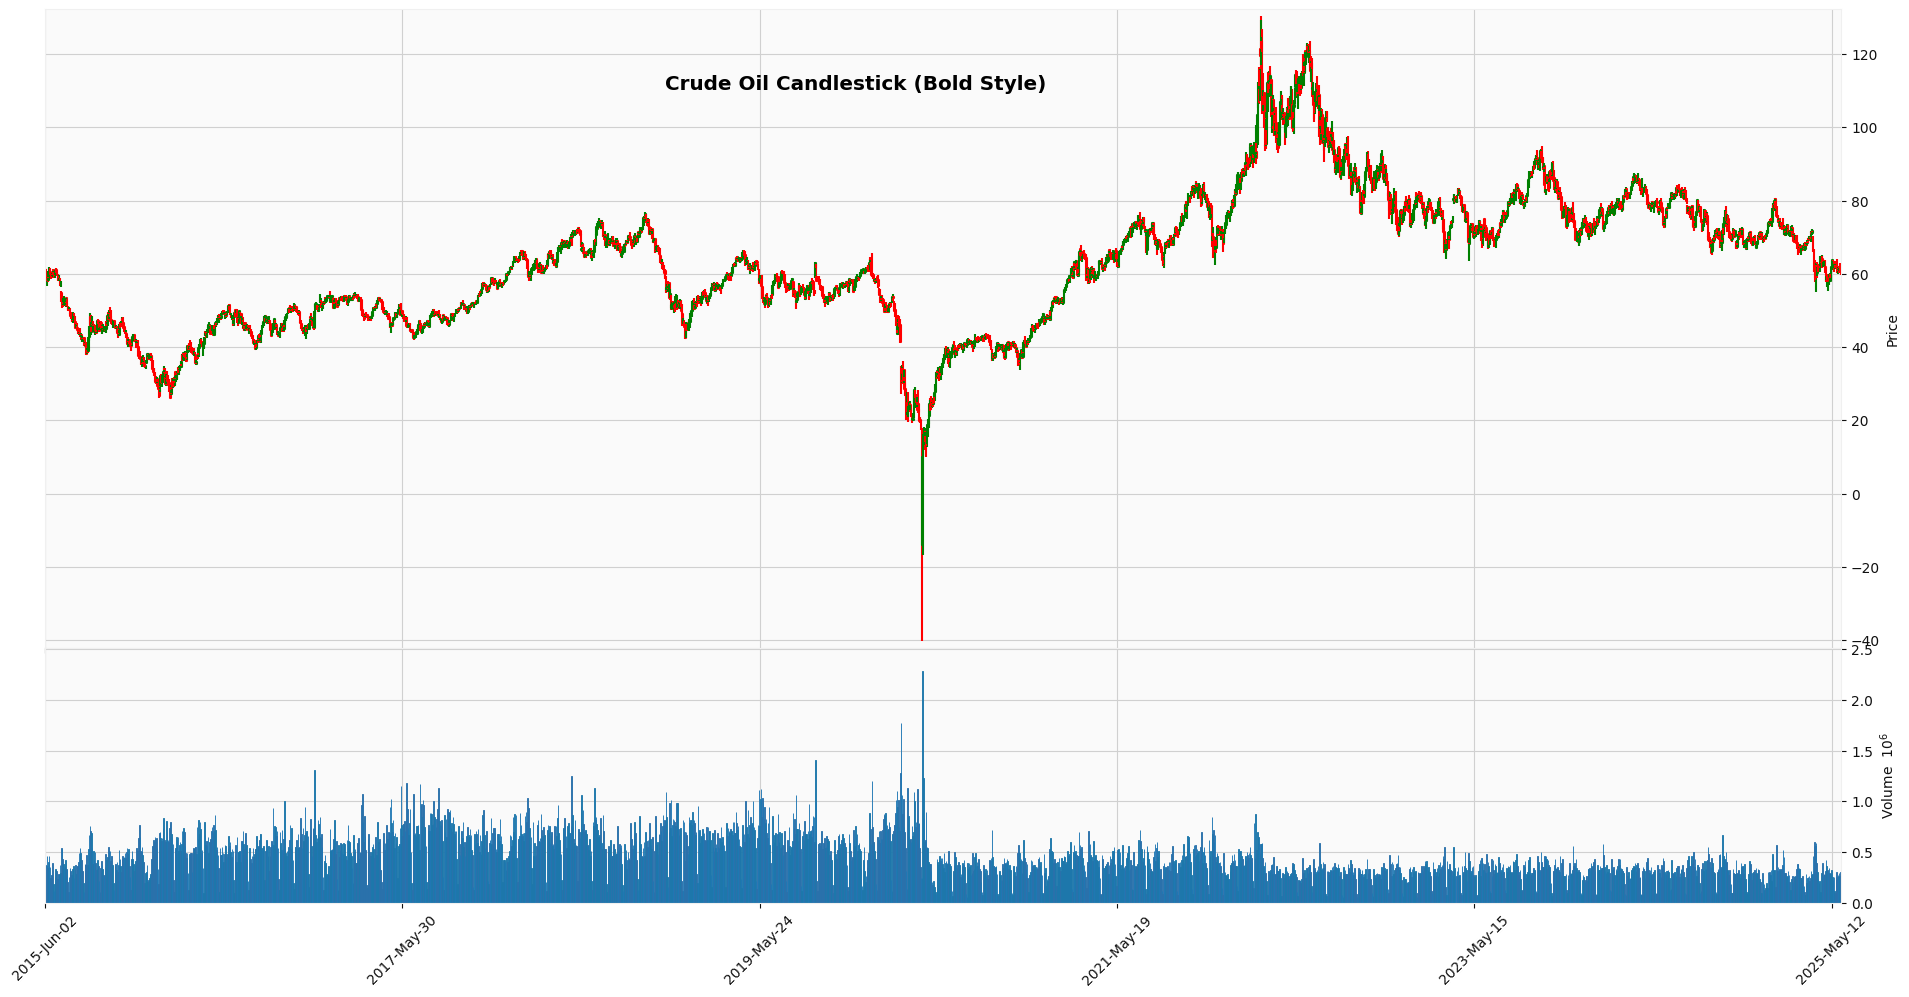

In [ ]:
import pandas as pd
import mplfinance as mpf

crude.columns = [col[0] if isinstance(col, tuple) else col for col in crude.columns]

crude.rename(columns={
    'Close': 'Close',
    'Open': 'Open',
    'High': 'High',
    'Low': 'Low',
    'Volume': 'Volume',
    'Date': 'Date'
}, inplace=True)



my_style = mpf.make_mpf_style(
    base_mpf_style='yahoo',
    rc={'font.size': 10},
    marketcolors=mpf.make_marketcolors(
        up='green', down='red',
        edge='inherit', wick={'up': 'green', 'down': 'red'},
        volume='in'
    )
)

mpf.plot(
    crude,
    type='candle',
    style=my_style,
    volume=True,
    title='Crude Oil Candlestick (Bold Style)',
    # mav=(10, 20, 50),
    figratio=(20, 10),
    figscale=1.8,
    tight_layout=True,
    update_width_config=dict(candle_linewidth=1.5, candle_width=0.9)
)


In [ ]:

crude = yf.download('CL=F', start='2015-06-02', end='2025-06-02')
crude.reset_index(inplace=True)

crude['Date'] = pd.to_datetime(crude['Date'])
crude.rename(columns={'Date': 'observation_date'}, inplace=True)

if isinstance(crude.columns, pd.MultiIndex):
    crude.columns = crude.columns.get_level_values(0)

df['observation_date'] = pd.to_datetime(df['observation_date'])
df = df.merge(crude[['observation_date', 'Volume']], on='observation_date', how='left')

df['Volume'] = df['Volume'].fillna(method='ffill')

[*********************100%***********************]  1 of 1 completed


In [ ]:
!pip install ta

In [ ]:
n_days = 30
df['return_30'] = df['DCOILWTICO'].pct_change(n_days)

delta = 0.05
df['regime'] = np.where(
    df['return_30'] > delta,
    'bull',
    np.where(df['return_30'] < -delta, 'bear', 'sideway')
)


In [ ]:
from ta.trend import MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from ta.utils import dropna

df= dropna(df)

rsi = RSIIndicator(close=df["DCOILWTICO"])
df["RSI"] = rsi.rsi()

macd = MACD(close=df["DCOILWTICO"])
df["MACD"] = macd.macd()
df["MACD_Signal"] = macd.macd_signal()

df["MA10"] = df["DCOILWTICO"].rolling(window=10).mean()
df["MA50"] = df["DCOILWTICO"].rolling(window=50).mean()

bollinger = BollingerBands(close=df["DCOILWTICO"])
df["BB_High"] = bollinger.bollinger_hband()
df["BB_Low"] = bollinger.bollinger_lband()




In [ ]:
df.head()

,observation_date,DCOILWTICO,Volume,RSI,MACD,MA10
0,2015-06-02,61.30,344508.0,NaN,NaN,NaN
1,2015-06-03,59.67,371298.0,NaN,NaN,NaN
2,2015-06-04,58.00,363345.0,NaN,NaN,NaN
3,2015-06-05,59.11,461016.0,NaN,NaN,NaN
4,2015-06-08,58.15,339845.0,NaN,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2577 entries, 30 to 2609
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   observation_date  2577 non-null   datetime64[ns]
 1   DCOILWTICO        2577 non-null   float64       
 2   Volume            2577 non-null   float64       
 3   return_30         2577 non-null   float64       
 4   regime            2577 non-null   object        
 5   RSI               2564 non-null   float64       
 6   MACD              2552 non-null   float64       
 7   MACD_Signal       2544 non-null   float64       
 8   MA10              2568 non-null   float64       
 9   MA50              2528 non-null   float64       
 10  BB_High           2558 non-null   float64       
 11  BB_Low            2558 non-null   float64       
dtypes: datetime64[ns](1), float64(10), object(1)
memory usage: 261.7+ KB


                  observation_date  DCOILWTICO    Volume       RSI      MACD  \
observation_date          1.000000    0.647733 -0.458537  0.019264 -0.007635   
DCOILWTICO                0.647733    1.000000 -0.356170  0.174161  0.245910   
Volume                   -0.458537   -0.356170  1.000000 -0.079013 -0.084750   
RSI                       0.019264    0.174161 -0.079013  1.000000  0.779666   
MACD                     -0.007635    0.245910 -0.084750  0.779666  1.000000   
MACD_Signal              -0.011144    0.258451 -0.066072  0.651622  0.955069   
MA10                      0.655450    0.988851 -0.347284  0.073500  0.185381   
MA50                      0.681354    0.945487 -0.341043 -0.112981 -0.074858   
BB_High                   0.667550    0.960765 -0.340363 -0.023130  0.055759   
BB_Low                    0.635226    0.967136 -0.336480  0.033273  0.144065   

                  MACD_Signal      MA10      MA50   BB_High    BB_Low  
observation_date    -0.011144  0.655450  0.6813

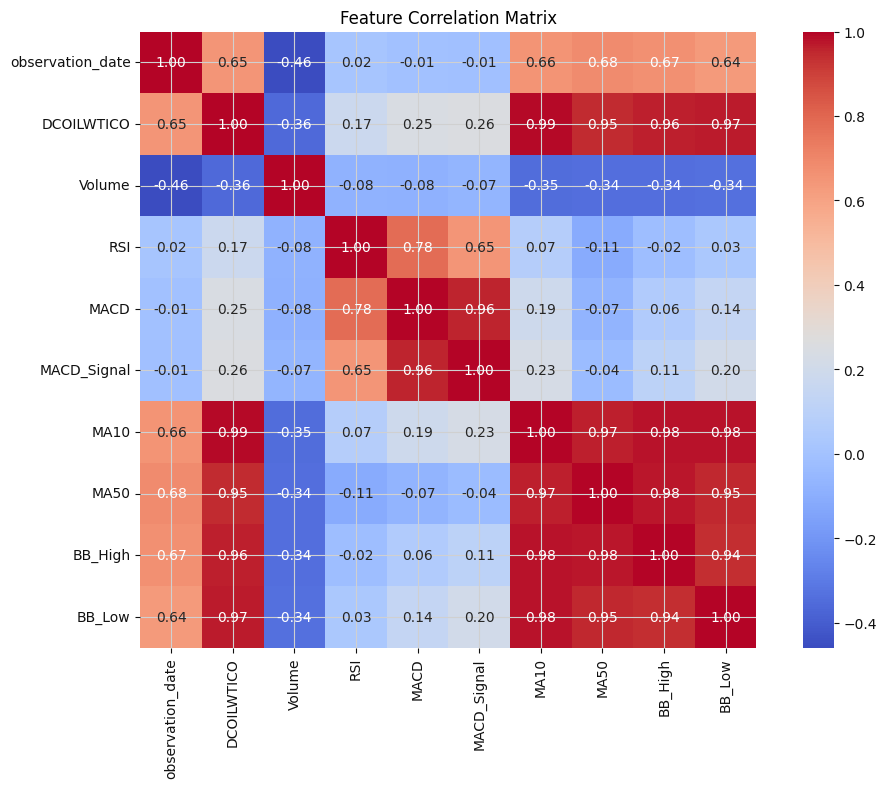

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
# df=df.drop(['regime'],axis=1)
corr_matrix = df.corr()
print(corr_matrix)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Feature Correlation Matrix')
plt.show()


In [ ]:
df=df.drop(['MACD_Signal','MA50','BB_High','BB_Low'],axis=1)
df.head()

,observation_date,DCOILWTICO,Volume,RSI,MACD,MA10
0,2015-06-02,61.30,344508.0,NaN,NaN,NaN
1,2015-06-03,59.67,371298.0,NaN,NaN,NaN
2,2015-06-04,58.00,363345.0,NaN,NaN,NaN
3,2015-06-05,59.11,461016.0,NaN,NaN,NaN
4,2015-06-08,58.15,339845.0,NaN,NaN,NaN


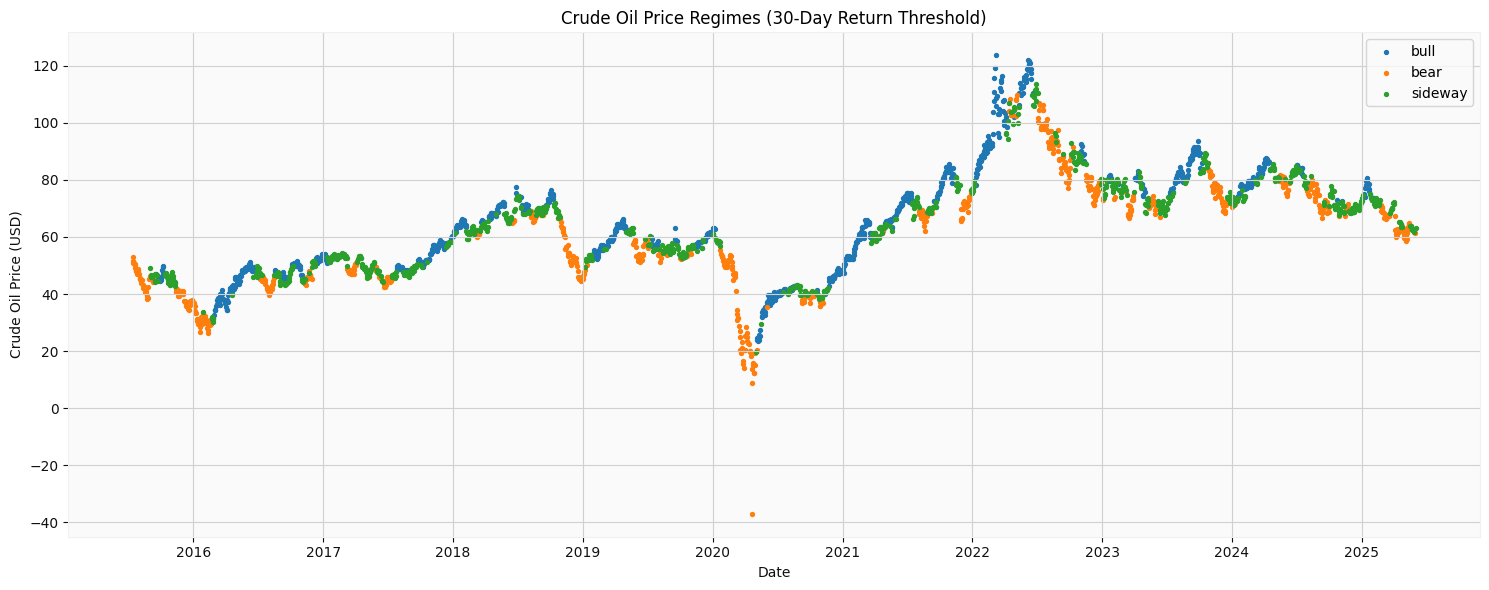

In [ ]:
plt.figure(figsize=(15, 6))
for regime in ['bull', 'bear', 'sideway']:
    mask = df['regime'] == regime
    plt.scatter(df.loc[mask, 'observation_date'],
                df.loc[mask, 'DCOILWTICO'],
                label=regime,
                s=8)
plt.xlabel('Date')
plt.ylabel('Crude Oil Price (USD)')
plt.title('Crude Oil Price Regimes (30-Day Return Threshold)')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
df.columns

Index(['observation_date', 'DCOILWTICO', 'Volume', 'return_30', 'RSI', 'MACD'], dtype='object')

In [ ]:
df=df.to_csv('/content/drive/My Drive/FinalOIL.csv')